In [158]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Explorative analysis of CT scans


(512, 512)
int16


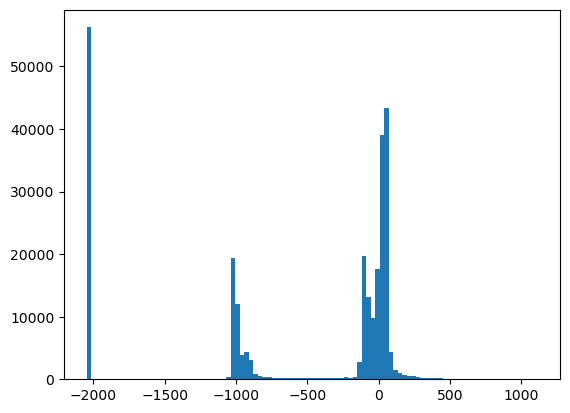

In [4]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)
plt.hist(img.flatten(), bins=100);

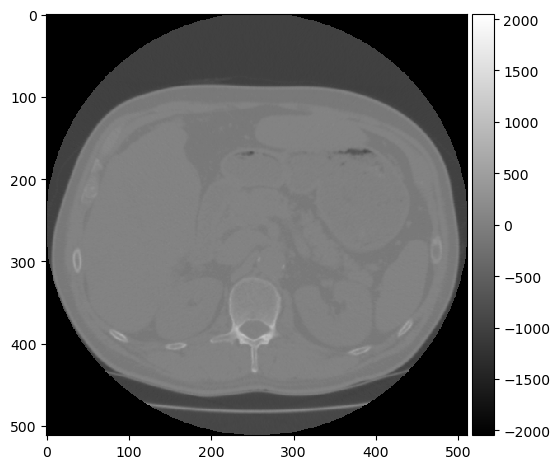

In [5]:
io.imshow(img, cmap="gray")

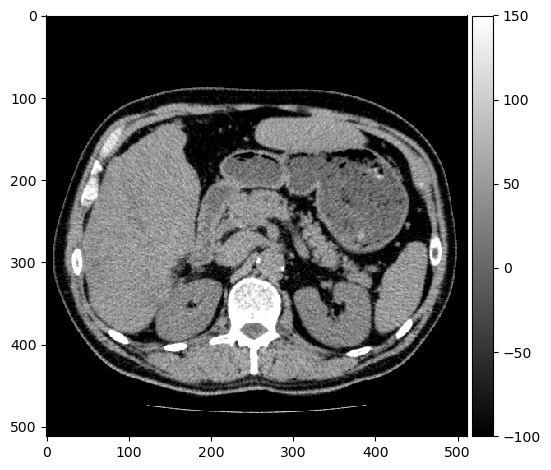

In [15]:
io.imshow(img, cmap="gray", vmin=-100, vmax=150)

### Masked and labeled data

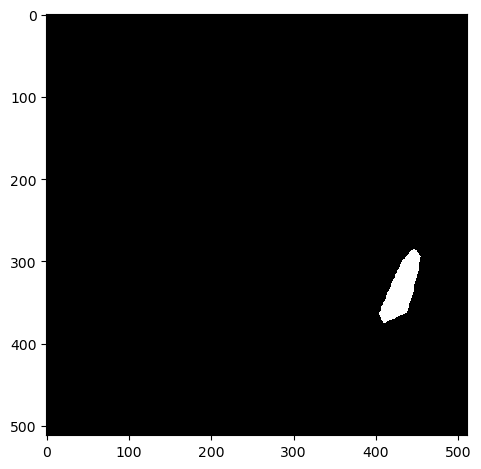

In [17]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]
io.imshow(spleen_mask)

### Exercise 2: 
Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

In [22]:
#Average and standard deviation of the spleen
print("Mean: ", spleen_values.mean())
print("Std: ", spleen_values.std())

Mean:  49.48026905829597
Std:  14.9970794143059


Not exactly, plot (not shown here) indicate a value from 0-150 with (est from simple plot) mean of 75, but it's not that far away.

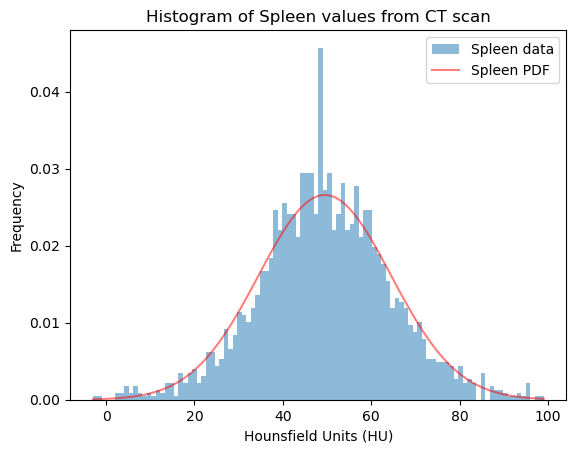

In [25]:

n, bins, patches = plt.hist(spleen_values, bins=100, alpha=0.5, label='Spleen data', density=1)
pdf_spleen = norm.pdf(bins, spleen_values.mean(), spleen_values.std())
plt.plot(bins, pdf_spleen, 'r', label='Spleen PDF', alpha=0.5)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('Histogram of Spleen values from CT scan')
plt.legend()
plt.show()

### Exercise 4
Fit several of the tissue types do they all look like they are gaus dist?


In [39]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array

In [40]:
img_list = ['BoneROI.png', 'LiverROI.png', 'FatROI.png', 'KidneyROI.png', 'SpleenROI.png', 'BackgroundROI.png']
#import defalt dictionary
from collections import defaultdict
img_dict = defaultdict()
for img_name in img_list:
    img_roi = io.imread(in_dir + img_name)
# convert to boolean image
    roi_mask = img_roi > 0
    img_dict[img_name] = img[roi_mask]

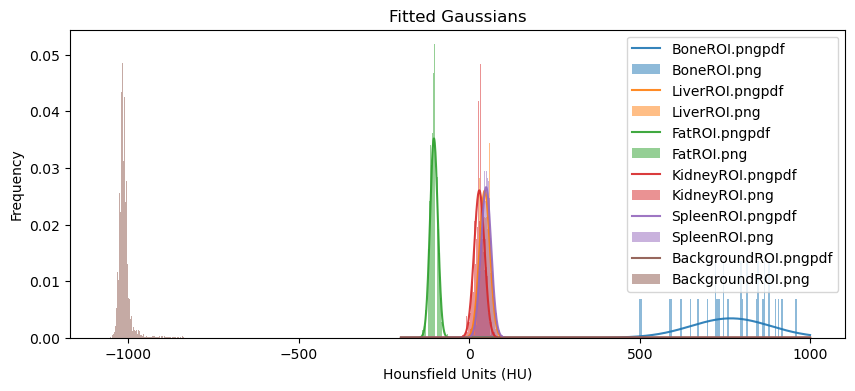

In [58]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

fix,ax = plt.subplots(figsize=(10, 4))
for i, img in enumerate(img_dict):
    color_rnd = COLORS[i]
    mu = img_dict[img].mean()
    std = img_dict[img].std()
    pdf = norm.pdf(hu_range, mu, std)
    plt.plot(hu_range, pdf, label=img+'pdf', alpha=0.9, color=color_rnd)
    plt.hist(img_dict[img], bins=100, alpha=0.5, label=img, density=1, color=color_rnd)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title("Fitted Gaussians")
plt.legend()
#increase plot size

plt.show()

As seen on the plot, BoneROI does not look like a Gaussian distribution. The other distributions look like Gaussian distributions. Seperating Liver and Kidney is not easy with a Gaussian distribution, but the other distributions are.

### Exercise 7
In the minimum distance classifier the pixel value class ranges are defined using the average values of the training values. If you have two classes, the threshold between them is defined as the mid-point between the two class value averages.

In the following, we will define four classes: background, fat, soft tissue and bone, where soft-tissue is a combination of the values of the spleen, liver and kidneys. We manually set the threshold for background to -200. So all pixels below -200 are set to background.

Exercise 7: Compute the class ranges defining fat, soft tissue and bone.

In [60]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array

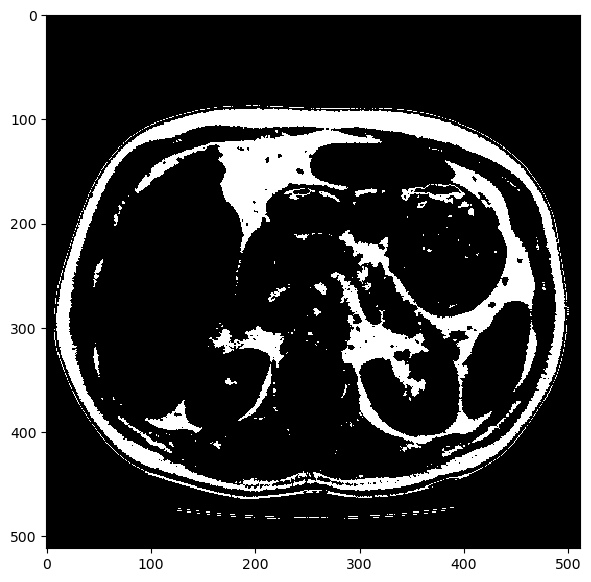

In [63]:
t_background = -200
t_fat_soft = -50
fat_img = (img > t_background) & (img <= t_fat_soft)

fix,ax = plt.subplots(figsize=(6, 6))
io.imshow(fat_img)

#### Exercise 8: Create class images: 
fat_img, soft_img and bone_img representing the fat, soft tissue and bone found in the image.

To visualize the classification results you can use:

In [65]:
t_background = -200
t_fat_soft = -50
t_soft_bone = 250
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = (img > t_soft_bone)

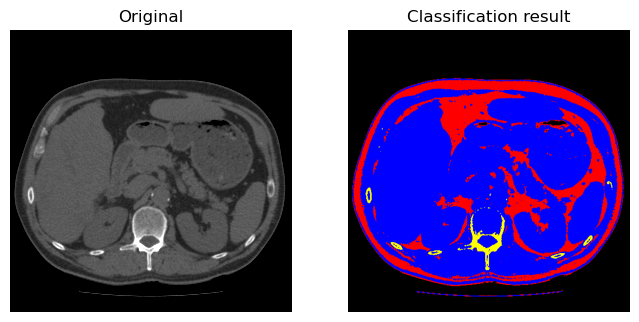

In [66]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

## Parametric pixel classification
In the parametric classifier, the standard deviation of the training pixel values is also used when determinin the class ranges. In the following, we are also trying to classify background, fat, soft tissue and bone.

We start by finding the class ranges by manually inspecting the fitted Gaussians from each class.

As in the last exercise, we can still se the background-fat threshold to be -200.

### Exercise 9: 
Plot the fitted Gaussians of the training values and manually find the intersection between the curves.

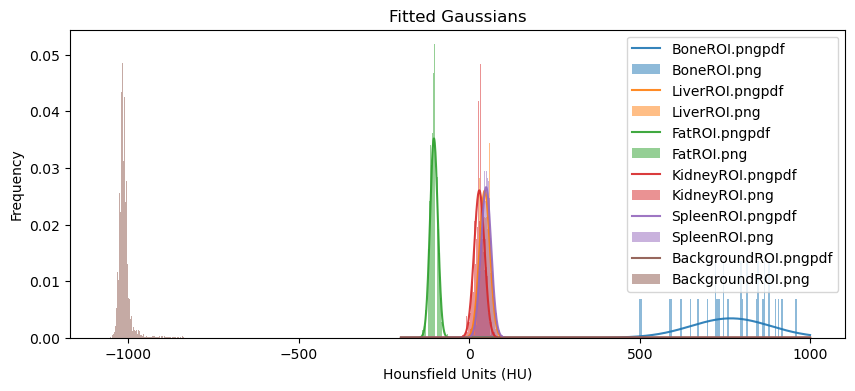

In [68]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

data_dict = defaultdict()

fix,ax = plt.subplots(figsize=(10, 4))
for i, img in enumerate(img_dict):
    color_rnd = COLORS[i]
    mu = img_dict[img].mean()
    data_dict[ img + 'mean'] = mu
    std = img_dict[img].std()
    data_dict[ img + 'std'] = std
    pdf = norm.pdf(hu_range, mu, std)
    plt.plot(hu_range, pdf, label=img+'pdf', alpha=0.9, color=color_rnd)
    plt.hist(img_dict[img], bins=100, alpha=0.5, label=img, density=1, color=color_rnd)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title("Fitted Gaussians")
plt.legend()
#increase plot size

plt.show()

Intersection of the gaussians might shift a bit but manually inspecting them is difficult due to the scale...Not a big difference here as long as we are not trying to seperate Kidney and Spleen and Liver

### Exercise 11, highest probability classifier

In [69]:
data_dict

defaultdict(None,
            {'BoneROI.pngmean': 766.9375,
             'BoneROI.pngstd': 116.56353886936515,
             'LiverROI.pngmean': 45.40611510791367,
             'LiverROI.pngstd': 15.35346721138944,
             'FatROI.pngmean': -103.39037725533078,
             'FatROI.pngstd': 11.323207120153308,
             'KidneyROI.pngmean': 29.614603174603175,
             'KidneyROI.pngstd': 15.31612003018511,
             'SpleenROI.pngmean': 49.48026905829597,
             'SpleenROI.pngstd': 14.9970794143059,
             'BackgroundROI.pngmean': -1011.1688530104271,
             'BackgroundROI.pngstd': 18.96474889282835})

In [120]:
mu_soft = (data_dict['LiverROI.pngmean']+data_dict['SpleenROI.pngmean']+data_dict['KidneyROI.pngmean'])/3
std_soft = (data_dict['LiverROI.pngstd']+data_dict['SpleenROI.pngstd']+data_dict['KidneyROI.pngstd'])/3
mu_fat = data_dict['FatROI.pngmean']
std_fat = data_dict['FatROI.pngstd']
mu_bone = data_dict['BoneROI.pngmean']
std_bone = data_dict['BoneROI.pngstd']
mu_background = data_dict['BackgroundROI.pngmean']
std_background = data_dict['BackgroundROI.pngstd']

#Define mu and std for soft tissue and bone as the default values in the function
def classify_hu(test_value: int, mu_soft=mu_soft, std_soft=std_soft, mu_bone=mu_bone, std_bone=std_bone):
	if test_value < mu_background:
		print(f"For value {test_value} the class is background")
		return(0)
	elif test_value < mu_fat:
		if norm.pdf(test_value, mu_background, std_background) > norm.pdf(test_value, mu_fat, std_fat):
			print(f"For value {test_value} the class is background")
			return(0)
		else:
			print(f"For value {test_value} the class is fat")
			return(1)
	elif test_value < mu_soft:
		if norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft):
			print(f"For value {test_value} the class is fat")
			return(1)
		else:
			print(f'For value {test_value} the class is soft tissue')
			return(2)
	elif test_value < mu_bone:
		if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
			print(f"For value {test_value} the class is soft tissue")
			return(2)
		else:
			print(f"For value {test_value} the class is bone")
			return(3)
	else:
		print(f"For value {test_value} the class is bone")
		return(3)

In [121]:
print(classify_hu(-2000))

For value -2000 the class is background
0


In [130]:
#Create table with the HU values and the corresponding class, from the min to max HU values of the image
min_hu = img.min()
max_hu = img.max()
hu_range = np.arange(min_hu, max_hu+1, 1.0)
hu_class = defaultdict()
for hu in hu_range:
    hu_class[hu] = classify_hu(hu)

For value -2048.0 the class is background
For value -2047.0 the class is background
For value -2046.0 the class is background
For value -2045.0 the class is background
For value -2044.0 the class is background
For value -2043.0 the class is background
For value -2042.0 the class is background
For value -2041.0 the class is background
For value -2040.0 the class is background
For value -2039.0 the class is background
For value -2038.0 the class is background
For value -2037.0 the class is background
For value -2036.0 the class is background
For value -2035.0 the class is background
For value -2034.0 the class is background
For value -2033.0 the class is background
For value -2032.0 the class is background
For value -2031.0 the class is background
For value -2030.0 the class is background
For value -2029.0 the class is background
For value -2028.0 the class is background
For value -2027.0 the class is background
For value -2026.0 the class is background
For value -2025.0 the class is bac

In [131]:
print(hu_class[60])

2


In [132]:
#Calculate the intersection of the gaussians on the x axis
def intersection(mu1, std1, mu2, std2):
    return (mu1*std2**2 + mu2*std1**2)/(std1**2 + std2**2)

#Calculate the intersection of the gaussians, soft, fat, bone and background
background_intersection = intersection(mu_background, std_background, mu_fat, std_fat)
fat_intersection = intersection(mu_fat, std_fat, mu_soft, std_soft)
soft_intersection = intersection(mu_soft, std_soft, mu_bone, std_bone)

print(f"Background and fat intersection: {background_intersection}")
print(f"Fat and soft tissue intersection: {fat_intersection}")
print(f"Soft tissue and bone intersection: {soft_intersection}")


Background and fat intersection: -341.956453834978
Fat and soft tissue intersection: -51.777259208973256
Soft tissue and bone intersection: 53.664608478173726


In [133]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array

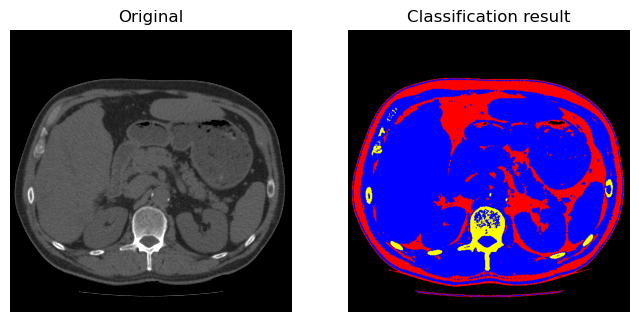

In [134]:
#Apply the classify_hu function to the image
label_img = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        label_img[i,j] = hu_class[img[i,j]]

image_label_overlay = label2rgb(label_img)

show_comparison(img, image_label_overlay, 'Classification result')

The classification does a good job at detecting the different tissues. 

## exercise 12:
### Object segmentation - The spleen finder
The goal of this part of the exercise, is to create a program that can automatically segment the spleen in CT images.

We start by using the Training.dcm image and the expert provided annotations.

Exercise 11: Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.

You can now use:

Mean:  49.48026905829597
Std:  14.9970794143059


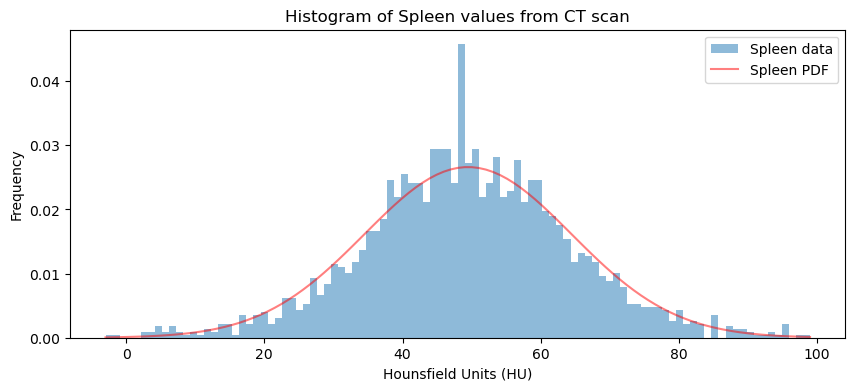

In [143]:
#Average and standard deviation of the spleen
print("Mean: ", spleen_values.mean())
print("Std: ", spleen_values.std())

plt.figure(figsize=(10, 4))
n, bins, patches = plt.hist(spleen_values, bins=100, alpha=0.5, label='Spleen data', density=1)
pdf_spleen = norm.pdf(bins, spleen_values.mean(), spleen_values.std())
#Set the plot size to 10, 4
plt.plot(bins, pdf_spleen, 'r', label='Spleen PDF', alpha=0.5)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('Histogram of Spleen values from CT scan')
plt.legend()
plt.show()

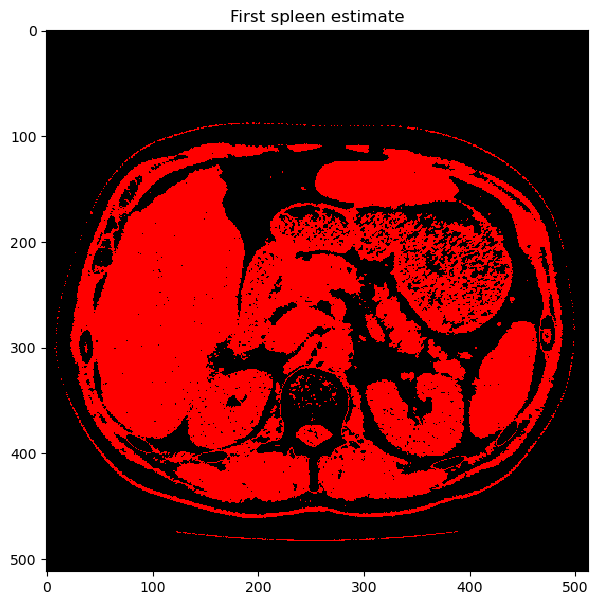

In [147]:
t_1 = 0
t_2 = 100
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
plt.figure(figsize=(10, 6))
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

In [151]:
from skimage import morphology

def apply_closing(img, disk_size):
    footprint = morphology.disk(disk_size)
    img_closed = morphology.closing(img,footprint)
    return img_closed

def apply_opening(img, disk_size):
    footprint = morphology.disk(disk_size)
    img_open = morphology.opening(img,footprint)
    return img_open

In [215]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    if len(original.shape) == 3: # RGB image
        ax1.imshow(original)
    elif np.max(original) > 255: # Hounsfield units
        ax1.imshow(original, cmap='gray', vmin=-200, vmax=500)
    else: # Grayscale image
        ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.set_title('Original')
    ax1.axis('off')
    if len(modified.shape) == 3: # RGB image
        ax2.imshow(modified)
    else: # Grayscale image
        ax2.imshow(modified, cmap='gray')
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

<Figure size 1000x1000 with 0 Axes>

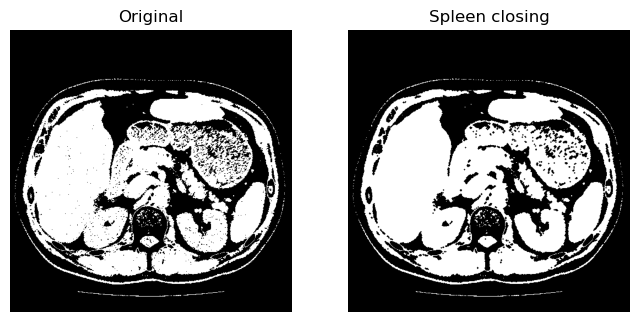

<Figure size 1000x1000 with 0 Axes>

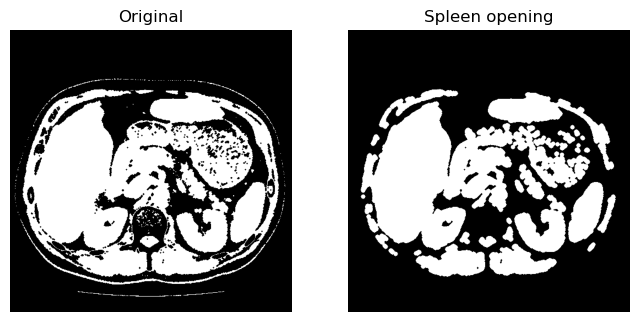

In [216]:
spleen_label_colour = color.label2rgb(spleen_estimate)
footprint = 1
spleen_closing = apply_closing(spleen_estimate, footprint)

plt.figure(figsize=(10, 10))
show_comparison(spleen_estimate, spleen_closing, 'Spleen closing')

footprint = 4
spleen_opening = apply_opening(spleen_closing, footprint)
plt.figure(figsize=(10, 10))
show_comparison(spleen_closing, spleen_opening, 'Spleen opening')


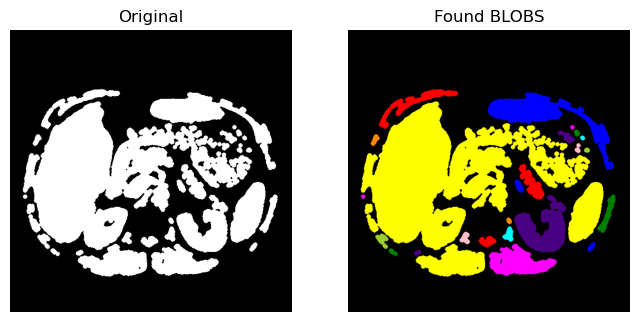

In [167]:
label_img = measure.label(spleen_opening)
image_label_overlay = label2rgb(label_img)
show_comparison(spleen_opening, image_label_overlay, 'Found BLOBS')

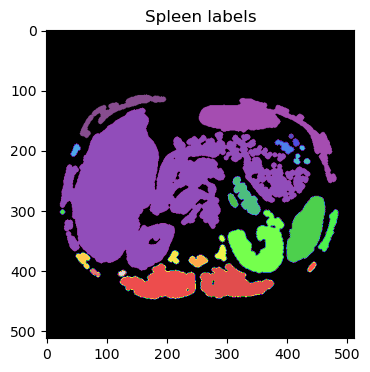

In [213]:
#Plot the label nunmbers on the image
plt.figure(figsize=(4, 4))
plt.imshow(spleen_opening, cmap='gray')
plt.imshow(label_img, cmap='nipy_spectral', alpha=0.7)
#add legends of the labels
plt.title("Spleen labels")
plt.show()

In [214]:
#plot the value of the pixel 350, 450 = The spleen
label_img[350, 420]

13

Area of the spleen: 4544 pixels


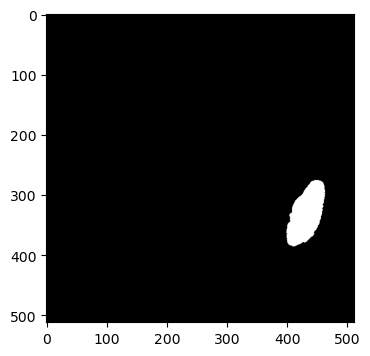

In [189]:
label_regions = measure.regionprops(label_img)
print(f'Area of the spleen: {label_regions[12].area} pixels')
#Make filter for the coordinates of the labels to verify that we selected the correct region
label_filter = np.zeros(label_img.shape)
for coord in label_regions[12].coords:
    label_filter[coord[0], coord[1]] = 1

plt.figure(figsize=(4, 4))
plt.imshow(label_filter, cmap='gray')

Text(0.5, 1.0, 'Histogram of Spleen areas from CT scan')

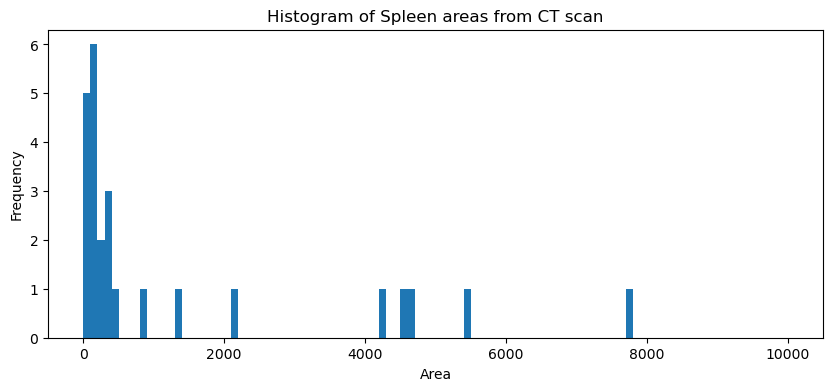

In [188]:
#Plot a histogram of the areas of each region of the labels of the range 1 to 10000
areas = [r.area for r in label_regions]
plt.figure(figsize=(10, 4))
plt.hist(areas, bins=100, range=(1, 10000))
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Spleen areas from CT scan')

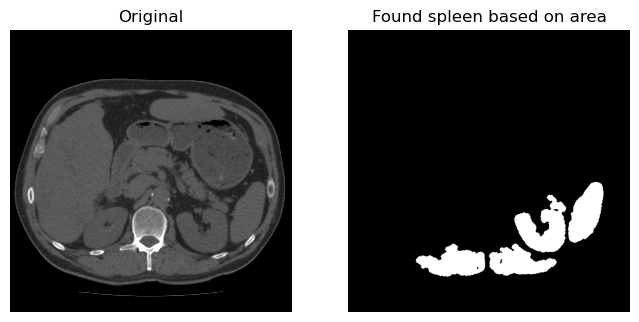

In [217]:
min_area = 3500
max_area = 5500

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in label_regions:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

Circularity of the spleen: 0.6248799108287036


Text(0.5, 1.0, 'Scatterplot of Spleen areas from CT scan')

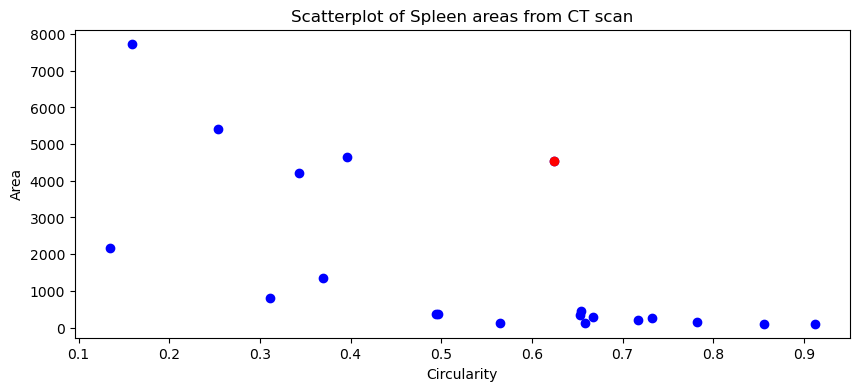

In [209]:
## If we are to include a reasonable range of the spleen we need to include other features as well, like the circularity of the object.
#Calculate the circularity of region[12] (Spleen)
label_regions[12].perimeter
label_regions[12].area
circularity = (4 * np.pi * label_regions[12].area) / (label_regions[12].perimeter ** 2)
print(f'Circularity of the spleen: {circularity}')

#Plot a scatterplot of circularity and area of all regions and colour the label_regions[12] in red
#Only plot values of the regions with area between 100 and 10000
plt.figure(figsize=(10, 4))
for region in label_regions:
    if region.area > 100 and region.area < 10000:
        plt.scatter((4 * np.pi * region.area) / (region.perimeter ** 2), region.area, color='blue')
plt.scatter((4 * np.pi * label_regions[12].area) / (label_regions[12].perimeter ** 2), label_regions[12].area, color='red')
plt.xlabel('Circularity')
plt.ylabel('Area')
plt.title('Scatterplot of Spleen areas from CT scan')


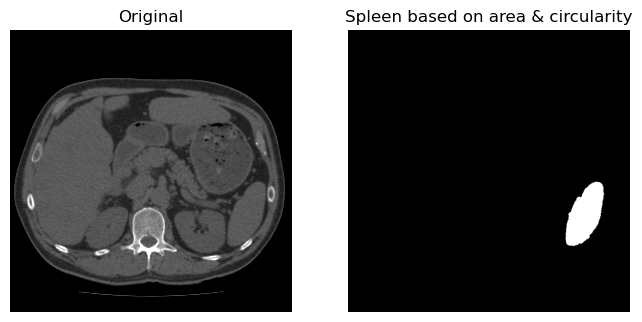

In [229]:
min_area = 3500
max_area = 5500
min_circularity = 0.55
max_circularity = 0.7

# Create a copy of the label_img
def spleen_detector(input_image):
    
    t_1 = 0
    t_2 = 100
    spleen_estimate = (input_image > t_1) & (input_image < t_2)
    # Apply closing to remove small holes
    spleen_closing = apply_closing(spleen_estimate, 1)
    # Apply opening to remove small objects
    spleen_opening = apply_opening(spleen_closing, 4)
    # Label the regions
    label_img = measure.label(spleen_opening)
    # Find the regions
    label_regions = measure.regionprops(label_img)
    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in label_regions:
        # Find the areas that do not fit our criteria
        # Calculate the circularity of the region
        circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
        if region.area > max_area or region.area < min_area or circularity > max_circularity or circularity < min_circularity:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    i_area = label_img_filter > 0
    return i_area

i_area = spleen_detector(img)

show_comparison(img, i_area, 'Spleen based on area & circularity')

### Exercise 16: 
Test your function on the images called Validation1.dcm, Validation2.dcm and Validation3.dcm. Do you succeed in finding the spleen in all the validation images?

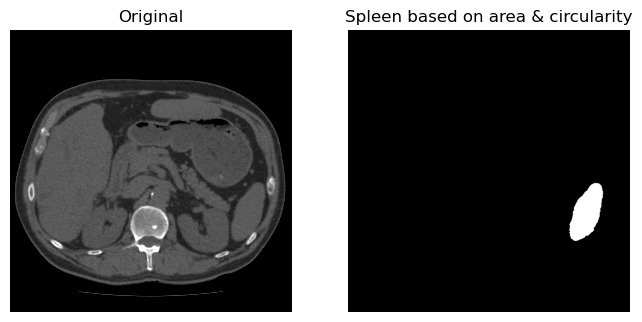

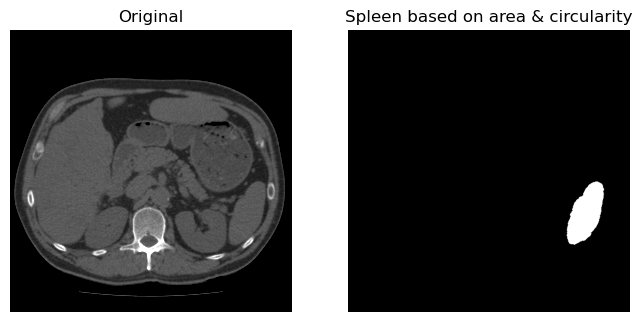

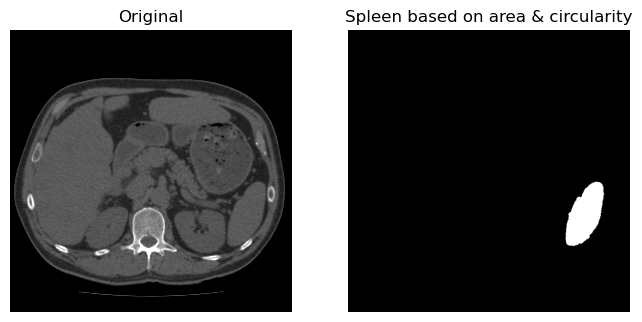

In [230]:
validation_images = ['Validation1.dcm', 'Validation2.dcm', 'Validation3.dcm']
in_dir = "data/"
bin_spleen = []
for image in validation_images:
    ct = dicom.read_file(in_dir + image)
    img = ct.pixel_array
    i_area = spleen_detector(img)
    bin_spleen.append(i_area)
    show_comparison(img, i_area, 'Spleen based on area & circularity')

## DICE Score
We would like evaluate how good we are at finding the spleen by comparing our found spleen with ground truth annotations of the spleen. The DICE score (also called the DICE coefficient or the DICE distance) is a standard method of comparing one segmentation with another segmentation.

If segmentation one is called X and the second segmentation called Y. The DICE score is computed as:

\text{DICE} = \frac{2 |X \cap Y|}{|X| + |Y|}

where 
 is the area (in pixels) of the overlap of the two segmentations and is 
 the area of the union of the two segmentation. This can be visualized as:

In [227]:
#Calculate the DICE score for the 3 validation images
validation_images = ['Validation1_spleen.png', 'Validation2_spleen.png', 'Validation3_spleen.png']
in_dir = "data/"
val_spleen = []
for image in validation_images:
    val_img = plt.imread(in_dir + image)
    bin_val = val_img > 0
    val_spleen.append(bin_val)

#Calculate the DICE score for the 3 validation images
dice_scores = []
for i in range(3):
    dice_score = 1 - distance.dice(bin_spleen[i].flatten(), val_spleen[i].flatten())
    dice_scores.append(dice_score)
print(f'DICE scores: {dice_scores}')

DICE scores: [0.967587609137663, 0.971872164532715, 0.9770491803278688]


Congratulations Jesper, you nailed it!


### Exercise 18, Testing on independent test set

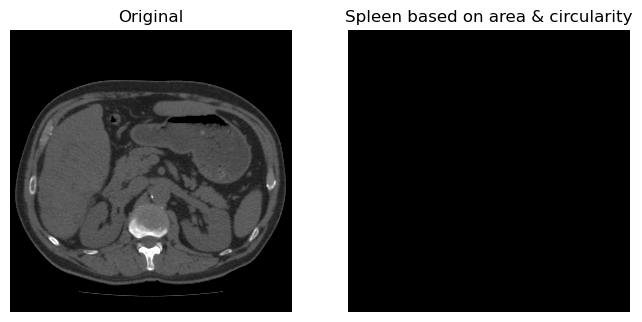

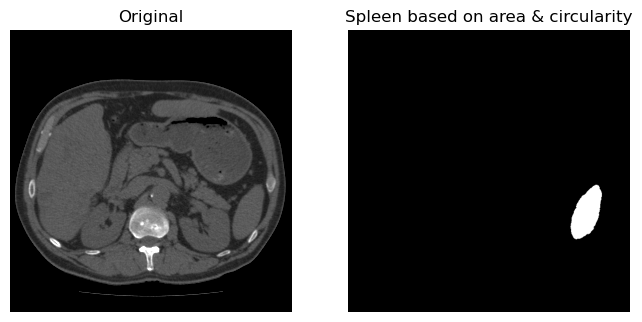

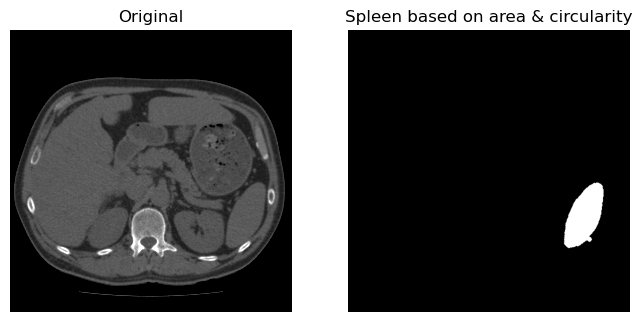

In [232]:
validation_images = ['Test1.dcm', 'Test2.dcm', 'Test3.dcm']
in_dir = "data/"
bin_spleen = []
for image in validation_images:
    ct = dicom.read_file(in_dir + image)
    img = ct.pixel_array
    i_area = spleen_detector(img)
    bin_spleen.append(i_area)
    show_comparison(img, i_area, 'Spleen based on area & circularity')

Damn

In [233]:
#Calculate the DICE score for the 3 validation images
validation_images = ['Test1_spleen.png', 'Test2_spleen.png', 'Test2_spleen.png']
in_dir = "data/"
val_spleen = []
for image in validation_images:
    val_img = plt.imread(in_dir + image)
    bin_val = val_img > 0
    val_spleen.append(bin_val)

#Calculate the DICE score for the 3 validation images
dice_scores = []
for i in range(3):
    dice_score = 1 - distance.dice(bin_spleen[i].flatten(), val_spleen[i].flatten())
    dice_scores.append(dice_score)
print(f'DICE scores: {dice_scores}')

DICE scores: [0.0, 0.9607167470709855, 0.8025338575797292]


Not so great after all!